In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

In [280]:
import grad_lib
import importlib
importlib.reload(grad_lib)
from grad_lib import Tensor, ReLU, FeedForward, Softmax, LinearLayer, Log 

In [95]:
from sklearn.datasets import load_digits

In [96]:
data=load_digits()

In [97]:
imgs=data['data']
target=data['target']

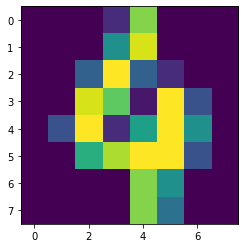

In [7]:
plt.imshow(imgs[100].reshape(8,8))

In [98]:
img_norml=imgs/16

In [211]:

class ConvNet2D:
    def __init__(self,kernel_size,img_size=(8,8),stride=1,padding=0):
        """[summary]

        Args:
            kernel_size ([type]): [description]
            img_size (tuple, optional): [description]. Defaults to (8,8).
            stride (int, optional): [description]. Defaults to 1.
            padding (int, optional): [description]. Defaults to 0.
        """
        self.img_size=img_size
        self.stride=stride
        self.pad=padding
        self.kernel_shape=(kernel_size,kernel_size)

        weight, bias=self.init_param()
        self.kernel=Tensor(weight.reshape(1,-1),requires_grad=True)
        self.bias=Tensor(bias,requires_grad=True)

        self.out_dim=self.get_out_dim()
        self.relu=ReLU()
    
    def init_param(self):
        weight=np.random.normal(0,1,self.kernel_shape)
        bias=np.random.normal(0,1,(1,1))

        return weight, bias 

    def __call__(self,x):
        x_tensor=self.transform(x)
        out=self.kernel*x_tensor+self.bias
        out=self.relu(out)

        return out.squeeze(0) 

    def transform(self,x):
        """transform batch of images

        Args:
            x (numpy.array): (batch,S,S)

        Returns:
            Tensor: [description]
        """
        # x: array
        i_f=x.shape[1]+self.pad-self.kernel_shape[0]
        j_f=x.shape[2]+self.pad-self.kernel_shape[1]

        out_list=[]
        for k in range(x.shape[0]):
            out=np.zeros((1,2*self.kernel_shape[0]))
            for i in range(0,i_f+1,self.stride):
                for j in range(0,j_f+1,self.stride):
                    z=x[k,i:i+self.kernel_shape[0],j:j+self.kernel_shape[1]].reshape(1,-1)
                    out=np.concatenate([out,z],axis=0)
            out_list.append(out[1:])
        
        #out_list: [batch,num_neurons,2*kernel_size]
        out=np.array(out_list).transpose(2,0,1)
        return Tensor(out,requires_grad=False)

    def get_out_dim(self):
        test=np.zeros((1,self.img_size[0],self.img_size[1]))
        size=self.transform(test).shape

        return size[2]

In [219]:
class ConvClf:
    def __init__(self,img_size,hidden_dim,out_dim=1):
        """Convolutional Neural Network Classifier

        Args:
            img_size (tuple): (width,height)
            hidden_dim (int): number of hidden neurons
            out_dim (int, optional): number of class. Defaults to 1.
        """
        self.convnet=ConvNet2D(2,img_size)
        in_dim=self.convnet.out_dim
        self.in_layer=LinearLayer(in_dim,hidden_dim)
        self.out_layer=LinearLayer(hidden_dim,out_dim)
        self.softmax=Softmax()
        self.relu=ReLU()

    def __call__(self,x):
        """[summary]

        Args:
            x (numpy.array): input must be array, not Tensor

        Returns:
            probability: (batch,out_dim)
        """
        out=self.convnet(x)
        out=self.in_layer(out)
        out=self.relu(out)
        out=self.out_layer(out)
        prob=self.softmax(out)

        return prob

In [299]:
class CrossEntropyLoss:
    def __init__(self,model):
        self.model=model
        self.log=Log()

    def __call__(self,prob,y):
        """loss function

        Args:
            prob (probability Tensor): (batch,num_classes)
            y (array): (batch,1)
        """
        bsz=y.shape[0]
        prob_=prob[range(bsz),y[:,0]]
        loss=-self.log(prob_).sum(0)
        loss=(1/bsz)*loss 

        return loss

In [300]:
loss=CrossEntropyLoss(model=ConvClf)

In [333]:
model.convnet.__class__

__main__.ConvNet2D